# ROV control System with image classification:

The goal of this ongoing project is to create a control system for an underwater vehicle. The focus of this documentation is to detail the image classification feature of the control system to differentiate between dead fishes and alive fishes.

## Scraping for images:

Using requests to get the HTML source of the website and using beautiful soup to parse the HTML to find all image tags to scrape. The source I used was stock photos because it was free to use. However searching for dead fish, fish, rotten fish, etc... there were a lot of nonrelated photos so manual sorting is required. To automate scraping multiple pages, I utilized the page variable within the link and ran it in for a loop. In total, I have 223 photos per training class and 66 photos per testing class.

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib import request
import urllib
import os
import urllib


def scrape():
    x = 21
    i = 7000

    loop = True

    while loop:
        url_1 = "https://www.istockphoto.com/hk/search/2/image?phrase=fish&page="+str(x)
        
        

        page = request.urlopen(url_1)
        soup = BeautifulSoup(page)

        for item in soup.find_all("img"):
            print(item.get("src"))

            try:
                r = requests.get(item.get("src")).content

                with open("/Users/idanlau/Desktop/" + "ROV Image Detection/" +"Train/Alive/" + str(i+1) + ".jpg", "wb+") as f:
                    f.write(r)
                    i += 1

            except requests.exceptions.MissingSchema:
                pass

        x += 1

        if x == 40:
            loop = False

#scrape()

## Checking data:

I ran into some issues with not having the right file type so the code helps check if a jpg file is actually valid. Although it did not detect properly, it could still be of future use to detect the wrong file type.

In [ ]:
from os import listdir
import cv2
yourDirectory = "/Users/idanlau/Desktop/ROV Image Detection/Train/Alive/"
for filename in listdir(yourDirectory):
  print(filename)
  if filename.endswith(".jpg"):
    print(yourDirectory+filename)
    #cv2.imread('C:/tensorflow/models/research/object_detection/images/train/'+filename)
    cv2.imread(yourDirectory+filename)

## Importing libraries:

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [22]:
batch_size = 32
img_height = 180
img_width = 180

## Data:
With the folder stored on my laptop, I would call the path to my training data files. Then for the validation set (around 30 percent of the original data), I have already split it beforehand so then I called on the validation data files directory on val_ds. The two classes are alive and dead.

In [61]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/Users/idanlau/Desktop/ROV Image Detection/Train",
  seed=123,
  labels='inferred',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 446 files belonging to 2 classes.


In [62]:
class_names = train_ds.class_names
print(class_names)

['Alive', 'Dead']


In [63]:
val_ds = tf.keras.utils.image_dataset_from_directory(
   "/Users/idanlau/Desktop/ROV Image Detection/Test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 132 files belonging to 2 classes.


In [64]:
class_names = val_ds.class_names
print(class_names)

['Alive', 'Dead']


## Sample images scaled to 180 by 180

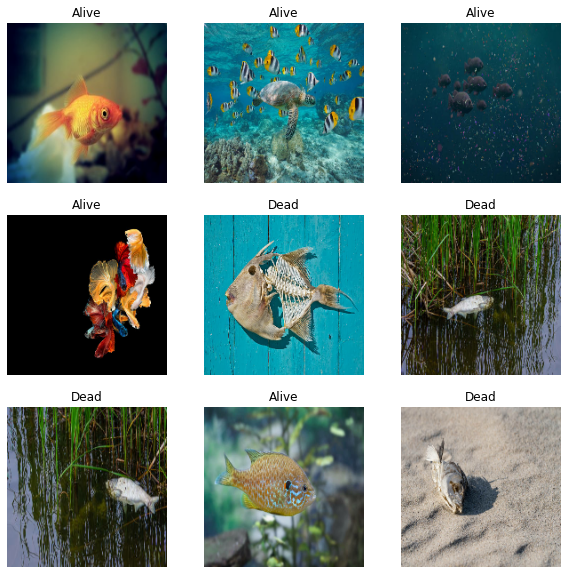

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Creating the model:

Below are the layers for the models, as seen it is a pretty standard layer build for image classification. With all images normalized and resized, applied layers and acitvation function and dropout layers to help minimize overfitting, the model is ready to go.

In [72]:
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [73]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 45, 45, 32)       

## Training model:
Overall the training time wasn't too long. The epochs is set to 5 since the accuracy does not change much after 5 epochs.

In [75]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
45/45 [==============================] - 11s 226ms/step - loss: 0.5240 - accuracy: 0.7287 - val_loss: 0.3209 - val_accuracy: 0.8712
Epoch 2/5
45/45 [==============================] - 10s 207ms/step - loss: 0.3041 - accuracy: 0.8991 - val_loss: 0.2500 - val_accuracy: 0.8864
Epoch 3/5
45/45 [==============================] - 10s 207ms/step - loss: 0.2041 - accuracy: 0.9327 - val_loss: 0.2515 - val_accuracy: 0.8864
Epoch 4/5
45/45 [==============================] - 10s 219ms/step - loss: 0.1381 - accuracy: 0.9529 - val_loss: 0.2041 - val_accuracy: 0.9318
Epoch 5/5
45/45 [==============================] - 10s 212ms/step - loss: 0.0966 - accuracy: 0.9731 - val_loss: 0.2526 - val_accuracy: 0.9242


## Results:

Overall the validation results ended with a score of 0.92 which is decent in this context. However as seen from the validation accuracy and validation loss from the graphs, there is still some room for improvement since it is still showing signs of overfitting. As seen on the first graph, validation accuracy plateaus towards 3-4 epochs while the validation loss increases towards 3-4 epochs.

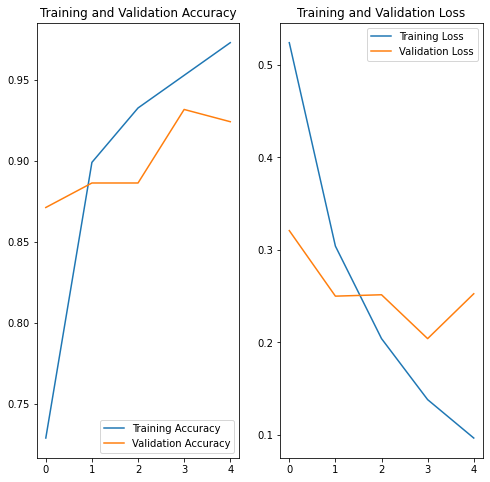

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Applying the model:
The model would be used later in other applications so for now, we can save the model onto a computer a load it when needed.

In [80]:
model.save("/Users/idanlau/Desktop/model")

INFO:tensorflow:Assets written to: /Users/idanlau/Desktop/model/assets


## Intergrating it with Cv2:
Here I have imported the trained Keras model and applied it to make predictions. The basic idea is to have OpenCV create a live camera feed, then draw contours based on silver colors(a temporary assumption that fishes all have some color similar to silver), capture the content within the contour, and pass it to the model for a prediction. The prediction will be drawn on the cropped image and display the certainty of its prediction.

In [ ]:
import cv2
import tensorflow as tf

from tensorflow import keras

import numpy as np

import time

def run():
    model = tf.keras.models.load_model(
        "/Users/idanlau/Desktop/model", custom_objects=None, compile=True, options=None
    )

    batch_size = 32
    img_height = 180
    img_width = 180

    train_ds = tf.keras.utils.image_dataset_from_directory(
      "/Users/idanlau/Desktop/ROV Image Detection/Train",
      seed=123,
      labels='inferred',
      image_size=(img_height, img_width),
      batch_size=batch_size)


    class_names = train_ds.class_names
    print(class_names)

    cap = cv2.VideoCapture(0)
    kernel = np.ones((2, 2), np.uint8)
    while (True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        org = (50, 50)

        # Our operations on the frame come here
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)
        gray = cv2.medianBlur(gray, 3)  # to remove salt and paper noise
        # to binary
        ret,thresh = cv2.threshold(gray,129,129,129) # to detect gray objects

        # to get outer boundery only
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, kernel)
        # to strength week pixels
        thresh = cv2.dilate(thresh, kernel, iterations=5)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        image = frame

        if len(contours) > 0:
            #cv2.drawContours(frame, contours, -1, (0, 255, 0), 5)
            # find the biggest countour (c) by the area
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)
            # draw the biggest contour (c) in green
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            image = frame[y:y+h,x:x+w]
            # Display the resulting frame
            # print(len(image))
            # print(len(frame))

            #cv2.imshow('frame', image)


            img = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)

            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Create a batch

            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])



            # fontScale
            fontScale = 1

            # Blue color in BGR
            color = (255, 0, 0)

            # Line thickness of 2 px
            thickness = 2

            font = cv2.FONT_HERSHEY_SIMPLEX

            frame = cv2.putText(frame, str(class_names[np.argmax(score)])+": "+str(100 * np.max(score)), org, font,
                           fontScale, color, thickness, cv2.LINE_AA)

            cv2.imshow('frame', frame)


            if cv2.waitKey(1) & 0xFF == ord('q'):
                cv2.imwrite('/Users/idanlau/Desktop/image.jpg', img)
                break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()


## Running examples:

### 6 examples:

1. The first photo identifies with high confidence that it is dead. However the rectangular contours seems to be off although still including the fish. ![title](1.png) 
2. The Second photo identifies well with high confidence that it is alive. The rectangular contours drawn well. ![title](2.png)
3. The third photo identifies well with high confidence that it is alive. The rectangular contours drawn well although could be a bit more accurate. ![title](3.png)
4. The fourth photo identifies mediocore with the correct classification that it is dead but with low confidence. The rectangular contours drawn well. ![title](4.png)
5. The fifth photo identifies poorly with the incorrect classification that the fish is alive when its dead. The rectangular contours drawn well.![title](5.png)
6. The fourth photo identifies poorly with the incorrect classification that the fish is alive when its dead. The rectangular contours drawn well.![title](6.png)

## Web application:
Here is a small snippet of another major feature I worked on which web pages to be updated asynchronously by exchanging small amounts of data with the server behind the scenes using ajax in vanilla JS. The data in this case are the keyboard inputs that will come in handy for sending signals through Django to the Raspberry pi underwater.

In [ ]:
<script>
document.addEventListener('keydown',makeRequest);



function makeRequest(event) {
    httpRequest = new XMLHttpRequest();

    //httpRequest.onreadystatechange = event.key;

    httpRequest.open("POST", '/test/', true);

   function getCookie(cname) {
    var name = cname + "=";
    var decodedCookie = decodeURIComponent(document.cookie);
    console.log(decodedCookie);
    var ca = decodedCookie.split(';');
    for(var i = 0; i <ca.length; i++) {
        var c = ca[i];
        while (c.charAt(0) == ' ') {
            c = c.substring(1);
        }
        if (c.indexOf(name) == 0) {

            return c.substring(name.length, c.length);
        }
    }
    return "";
}

    var csrftoken = getCookie('csrftoken');


    httpRequest.setRequestHeader("X-CSRFToken",csrftoken);
    httpRequest.setRequestHeader("Content-Type", "application/json;charset=UTF-8");
    //httpRequest.send({"data":event.key,"csrfmiddlewaretoken": csrf_token,});
    alert(event.key);
    httpRequest.send(event.key);
}

</script>

## Things to continue working on:

1. Border detection: Since an assumption is made that most fishes have somewhat of a gray color the threshold was set to gray. This is not true for all fishes so something like a fish feature detection might need to be implemented.

2. Accuracy: The model still has overfitting issues so the model needs more optimizing. There might be unwanted features that are used to classify as seen from inaccurate predictions made from the examples.

3. CV2 to Django: Allow cv2 to be used in Django so that everything can be in one application.